Este notebook ejecuta los dos modelos desarrollados para la solución con el segundo conjunto:
* Utilizando solo los datos de los sensores
* Utilizando los datos de los sensores y la hora actual

Para cada momento, se trata de predecir la siguiente actividad que se realizará, con los datos ya procesados en el notebook DataPrep2, donde se han creado las 3 subventanas de 30, 5 y 1 minuto. Con estos datos, se crean secuencias de 3 elementos, que sirven de entrada para la red neuronal


Es muy recomendable su ejecución en Google Colab con GPU

In [0]:
#Para cargar los datos en google colab
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten
from keras import initializers
from keras import optimizers

from keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import LSTM

from keras import backend as K

Using TensorFlow backend.


In [0]:
#Se configura el directorio de Google Drive donde se haya guardado el resultado del script DataPrep2
WINDOW_FILE='/content/gdrive/My Drive/data2_window_next'

### Funciones para calcular las métricas Recall, Precisión y F1

In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Gráficas para ver la evolución de las métricas

In [0]:
##Gráficas auxiliares para ver la evolución del accuracy y el loss
from matplotlib import pyplot as plt

def plot_acc(history, title="ACCURACY", ax=None):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)        
    ax.plot(history.history['acc'],linewidth=4.0)
    ax.plot(history.history['val_acc'],linewidth=4.0)
    ax.set_title(title,fontsize=20)
    #ax.set_ylabel('Accuracy',fontsize=20)
    ax.set_xlabel('Epoch',fontsize=20)
    ax.tick_params(labelsize=20)
    ax.legend(['Train', 'Val'], loc='lower right', prop={'size': 20})
    
def plot_loss(history, title="ERROR", ax=None):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)  
    ax.plot(history.history['loss'],linewidth=4.0)
    ax.plot(history.history['val_loss'],linewidth=4.0)
    ax.set_title(title,fontsize=20)
    #ax.set_ylabel('Loss',fontsize=20)
    ax.set_xlabel('Epoch',fontsize=20)
    ax.tick_params(labelsize=20)
    ax.legend(['Train', 'Val'], loc='upper right', prop={'size': 20})
    
def plot_precision(history, title="PRECISION", ax=None):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)  
    ax.plot(history.history['precision_m'],linewidth=4.0)
    ax.plot(history.history['val_precision_m'],linewidth=4.0)
    ax.set_title(title,fontsize=20)
    #ax.set_ylabel('Precision',fontsize=20)
    ax.set_xlabel('Epoch',fontsize=20)
    ax.tick_params(labelsize=20)
    ax.legend(['Train', 'Val'], loc='lower right', prop={'size': 20})

def plot_f1(history, title="F1", ax=None):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)  
    ax.plot(history.history['f1_m'],linewidth=4.0)
    ax.plot(history.history['val_f1_m'],linewidth=4.0)
    ax.set_title(title,fontsize=20)
    #ax.set_ylabel('F1',fontsize=20)
    ax.set_xlabel('Epoch',fontsize=20)
    ax.tick_params(labelsize=20)
    ax.legend(['Train', 'Val'], loc='lower right', prop={'size': 20})
    
def plot_recall(history, title="RECALL", ax=None):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)  
    ax.plot(history.history['recall_m'],linewidth=4.0)
    ax.plot(history.history['val_recall_m'],linewidth=4.0)
    ax.set_title(title,fontsize=20)
    #ax.set_ylabel('Recall',fontsize=20)
    ax.set_xlabel('Epoch',fontsize=20)
    ax.tick_params(labelsize=20)
    ax.legend(['Train', 'Val'], loc='lower right', prop={'size': 20})    
    
    
def plot_training(history):
    # Print learning progress
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))  
    plot_acc(history=history, ax=axs[0][0])
    plot_loss(history=history, ax=axs[0][1])
    plot_precision(history=history, ax=axs[0][2])
    plot_f1(history=history, ax=axs[1][0])
    axs[1,1].axis('off')
    plot_recall(history=history, ax=axs[1][2])
    fig.suptitle('Training Progress',fontsize=20)

## Se cargan los datos tras aplicar las ventanas

In [0]:
#Como se ha utilizado una función suma para crear el df de ventana, si el sensor se ha activado varias veces a lo largo de la ventana, el número indicado será >1.
#Se modifica para que si el flag del sensor >1, quede como 1
#En caso de que no se haya activado, quedará como 0

df_win=pd.read_csv(WINDOW_FILE,delimiter='|')
#Sensores de tipo flag
columns_sens_flag=['W1M001','W1M002','W1M003','W1M004','W1M005','W1M006','W1M007','W1M008','W1M009','W1M010','W1M011','W1M012','W1M013','W1M014',
         'W1M015','W1M016','W1M017','W1M018','W1M019','W1M020','W1M021','W1M022','W1M023','W1M024','W1M025','W1M026','W1M027',         
         'W5M001','W5M002','W5M003','W5M004','W5M005','W5M006','W5M007','W5M008','W5M009','W5M010','W5M011','W5M012','W5M013','W5M014',
         'W5M015','W5M016','W5M017','W5M018','W5M019','W5M020','W5M021','W5M022','W5M023','W5M024','W5M025','W5M026','W5M027',         
         'W30M001','W30M002','W30M003','W30M004','W30M005','W30M006','W30M007','W30M008','W30M009','W30M010','W30M011','W30M012','W30M013',
         'W30M014','W30M015','W30M016','W30M017','W30M018','W30M019','W30M020','W30M021','W30M022','W30M023','W30M024','W30M025','W30M026','W30M027']
#Todos los sensores
columns_sens=['W1M001','W1M002','W1M003','W1M004','W1M005','W1M006','W1M007','W1M008','W1M009','W1M010','W1M011','W1M012','W1M013','W1M014',
         'W1M015','W1M016','W1M017','W1M018','W1M019','W1M020','W1M021','W1M022','W1M023','W1M024','W1M025','W1M026','W1M027','W1T001','W1T002','W1T003','W1T004','W1T005',
         'W5M001','W5M002','W5M003','W5M004','W5M005','W5M006','W5M007','W5M008','W5M009','W5M010','W5M011','W5M012','W5M013','W5M014',
         'W5M015','W5M016','W5M017','W5M018','W5M019','W5M020','W5M021','W5M022','W5M023','W5M024','W5M025','W5M026','W5M027','W5T001','W5T002','W5T003','W5T004','W5T005',
         'W30M001','W30M002','W30M003','W30M004','W30M005','W30M006','W30M007','W30M008','W30M009','W30M010','W30M011','W30M012','W30M013',
         'W30M014','W30M015','W30M016','W30M017','W30M018','W30M019','W30M020','W30M021','W30M022','W30M023','W30M024','W30M025','W30M026','W30M027','W30T001','W30T002','W30T003','W30T004','W30T005']

df_win[columns_sens]=df_win[columns_sens].astype(float)

dfsenses=df_win[columns_sens_flag]
#Los sensores de tipo Flag, si no son 0, se dejan a 1
dfsenses[dfsenses[columns_sens_flag] != 0.0] = 1.0


df_win[columns_sens_flag]=dfsenses

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


## Output usando un One Hot encoding

In [0]:
#Se categoriza la columna actividad con un one hot encoding
df_win['next_activity'] = pd.Categorical(df_win['next_activity'])
df_output = pd.get_dummies(df_win['next_activity'])


## Input con secuencias de 3 elementos: 


*   Información de los sensores en los 30 últimos minutos
*   Información de los sensores en los 5 últimos minutos
*   Información de los sensores en el último minutos

In [0]:
sens1=['W1M001','W1M002','W1M003','W1M004','W1M005','W1M006','W1M007','W1M008','W1M009','W1M010','W1M011','W1M012','W1M013','W1M014',
         'W1M015','W1M016','W1M017','W1M018','W1M019','W1M020','W1M021','W1M022','W1M023','W1M024','W1M025','W1M026','W1M027','W1T001','W1T002','W1T003','W1T004','W1T005',]
sens5=['W5M001','W5M002','W5M003','W5M004','W5M005','W5M006','W5M007','W5M008','W5M009','W5M010','W5M011','W5M012','W5M013','W5M014',
         'W5M015','W5M016','W5M017','W5M018','W5M019','W5M020','W5M021','W5M022','W5M023','W5M024','W5M025','W5M026','W5M027','W5T001','W5T002','W5T003','W5T004','W5T005']
sens30=['W30M001','W30M002','W30M003','W30M004','W30M005','W30M006','W30M007','W30M008','W30M009','W30M010','W30M011','W30M012','W30M013',
         'W30M014','W30M015','W30M016','W30M017','W30M018','W30M019','W30M020','W30M021','W30M022','W30M023','W30M024','W30M025','W30M026','W30M027','W30T001','W30T002','W30T003','W30T004','W30T005']

#Se convierte a una matriz tridimensional donde las dimensiones son: ventana, posicion en la secuencia, tiempo
a=np.asarray([df_win[sens30].values,df_win[sens5].values,df_win[sens1].values])
df_in=np.rot90(a)

## Se separan los datos en train y test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_in, df_output, test_size=0.1)

# Se crea y entrena el Modelo
Tiene las siguientes capas:
* Input
* LSTM
* Dense
* Output


In [0]:
model = Sequential()
model.add(LSTM(512, input_shape=(3, X_train.shape[2])))
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.summary()

W0714 00:12:20.409608 140549685225344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 00:12:20.435170 140549685225344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 00:12:20.438488 140549685225344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512)               1116160   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 13)                1677      
Total params: 1,183,501
Trainable params: 1,183,501
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', patience=4)]
model = model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adagrad(),
              metrics=['accuracy',f1_m,precision_m, recall_m])

%time history = model.fit(X_train, y_train, batch_size=64, epochs=30, verbose=1, validation_split=0.2, callbacks=callbacks)

W0714 00:12:21.203489 140549685225344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0714 00:12:21.212059 140549685225344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0714 00:12:21.374610 140549685225344 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0714 00:12:21.994546 140549685225344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated

Train on 523010 samples, validate on 130753 samples
Epoch 1/30
523010/523010 [==============================] - 85s 162us/step - loss: 1.7672 - acc: 0.3937 - f1_m: 0.1933 - precision_m: 0.5953 - recall_m: 0.1245 - val_loss: 1.4314 - val_acc: 0.5234 - val_f1_m: 0.4229 - val_precision_m: 0.7555 - val_recall_m: 0.2958
Epoch 2/30
523010/523010 [==============================] - 83s 158us/step - loss: 0.9952 - acc: 0.6871 - f1_m: 0.6347 - precision_m: 0.8679 - recall_m: 0.5056 - val_loss: 2.0538 - val_acc: 0.4093 - val_f1_m: 0.3892 - val_precision_m: 0.4606 - val_recall_m: 0.3377
Epoch 3/30
523010/523010 [==============================] - 82s 156us/step - loss: 0.6394 - acc: 0.8101 - f1_m: 0.7920 - precision_m: 0.9188 - recall_m: 0.6981 - val_loss: 0.5550 - val_acc: 0.8389 - val_f1_m: 0.8275 - val_precision_m: 0.9311 - val_recall_m: 0.7460
Epoch 4/30
523010/523010 [==============================] - 81s 156us/step - loss: 0.4628 - acc: 0.8678 - f1_m: 0.8590 - precision_m: 0.9398 - recall_m: 

## Métricas de accuracy, f1, precision y recall

In [0]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test,y_test, batch_size=64)
print("Accuracy: "+ str(accuracy))
print("F1: "+ str(f1_score))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))

72641/72641 [==============================] - 4s 56us/step
Accuracy: 0.9728665629603117
F1: 0.9733256424300952
Precision: 0.9803571091997841
Recall: 0.9665065183557604


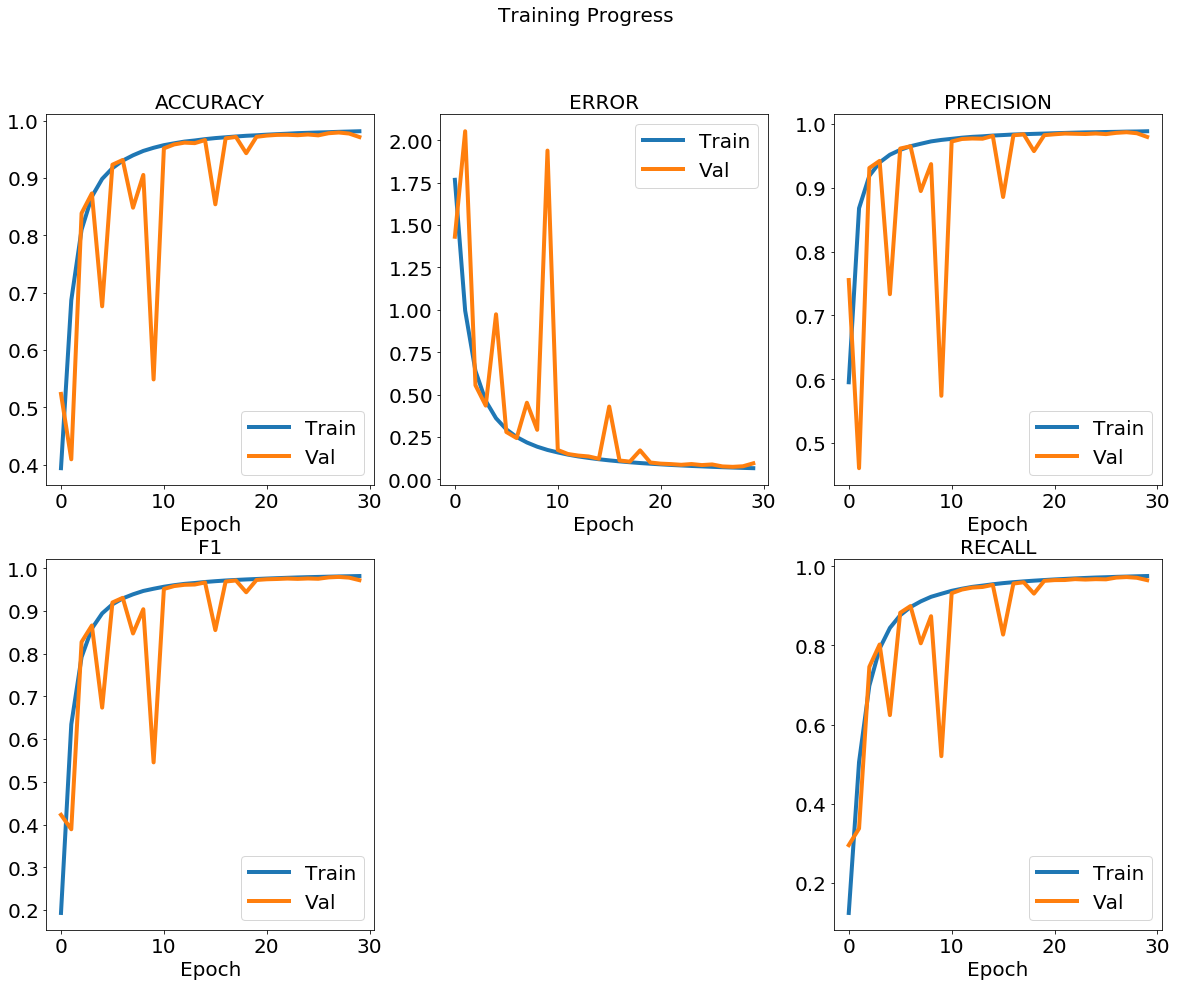

In [0]:
plot_training(history)
plt.show()

## Métricas para cada una de las categorías

In [0]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(np.asarray(y_test), axis=1)
y_pred = model.predict_classes(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       874
           1       0.98      0.94      0.95      1554
           2       0.98      0.99      0.98     14238
           3       0.99      0.97      0.98      1870
           4       0.97      0.99      0.98     13858
           5       0.99      0.98      0.98      8876
           6       0.97      0.98      0.97      2048
           7       0.97      0.93      0.95      2139
           8       0.97      0.95      0.96      5267
           9       0.99      0.99      0.99      4342
          10       0.99      0.99      0.99     12741
          11       0.98      0.97      0.97      2354
          12       0.98      0.95      0.96      2480

    accuracy                           0.98     72641
   macro avg       0.98      0.97      0.97     72641
weighted avg       0.98      0.98      0.98     72641



# Modelo incluyendo la información de la hora del momento que se está analizando

In [0]:
df_win_hour=df_win
#Para cada timestamp, se extrae únicamente la hora, de 0 a 23, y se convierte en un one hot encoding
df_win_hour['now'] = pd.to_datetime(df_win_hour['now'])
df_win_hour['hour'] = df_win_hour['now'].dt.hour
df_win_hour['hour'] = pd.Categorical(df_win_hour['hour'])
df_hour = pd.get_dummies(df_win_hour['hour'],prefix = 'hour')
df_win_hour = pd.concat([df_win_hour, df_hour], axis=1)
df_win_hour

,Unnamed: 0,W1M001,W1M002,W1M003,W1M004,W1M005,W1M006,W1M007,W1M008,W1M009,W1M010,W1M011,W1M012,W1M013,W1M014,W1M015,W1M016,W1M017,W1M018,W1M019,W1M020,W1M021,W1M022,W1M023,W1M024,W1M025,W1M026,W1M027,W1T001,W1T002,W1T003,W1T004,W1T005,W5M001,W5M002,W5M003,W5M004,W5M005,W5M006,W5M007,...,W30M021,W30M022,W30M023,W30M024,W30M025,W30M026,W30M027,W30T001,W30T002,W30T003,W30T004,W30T005,next_activity,activity,now,hour,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,19.000000,20.500000,20.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.500000,19.000000,20.500000,20.500000,Night_wandering,0,2009-06-10 00:00:00.024668,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,19.000000,20.500000,19.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.500000,19.000000,20.500000,19.500000,Night_wandering,0,2009-06-10 00:00:46.069471,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,18.833333,20.500000,19.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.500000,18.833333,20.500000,19.166667,Night_wandering,0,2009-06-10 00:00:47.047655,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,18.666667,20.500000,18.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.500000,18.750000,20.500000,18.875000,Night_wandering,0,2009-06-10 00:01:17.070215,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,18.625000,20.250000,18.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.500000,18.700000,20.300000,18.700000,Night_wandering,0,2009-06-10 00:01:18.036049,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,18.500000,20.000000,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.500000,18.666667,20.250000,18.583333,Night_wandering,0,2009-06-10 00:01:48.008924,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,18.625000,20.000000,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.500000,18.714286,20.214286,18.500000,Night_wandering,0,2009-06-10 00:01:49.034019,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,18.700000,19.900000,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.500000,18.750000,20.125000,18.437500,Night_wandering,0,2009-06-10 00:02:04.007968,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,18.666667,19.833333,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.500000,18.722222,20.055556,18.388889,Night_wandering,0,2009-06-10 00:02:04.033741,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.500000,20.5,18.700000,19.800

## Input con secuencias de 3 elementos: 


*   Información de los sensores en los 30 últimos minutos + hora actual
*   Información de los sensores en los 5 últimos minutos + hora actual
*   Información de los sensores en el último minutos+ hora actual

In [0]:
sens1=['W1M001','W1M002','W1M003','W1M004','W1M005','W1M006','W1M007','W1M008','W1M009','W1M010','W1M011','W1M012','W1M013','W1M014',
         'W1M015','W1M016','W1M017','W1M018','W1M019','W1M020','W1M021','W1M022','W1M023','W1M024','W1M025','W1M026','W1M027','W1T001','W1T002','W1T003','W1T004','W1T005',
      'hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23']
sens5=['W5M001','W5M002','W5M003','W5M004','W5M005','W5M006','W5M007','W5M008','W5M009','W5M010','W5M011','W5M012','W5M013','W5M014',
         'W5M015','W5M016','W5M017','W5M018','W5M019','W5M020','W5M021','W5M022','W5M023','W5M024','W5M025','W5M026','W5M027','W5T001','W5T002','W5T003','W5T004','W5T005',
      'hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23']
sens30=['W30M001','W30M002','W30M003','W30M004','W30M005','W30M006','W30M007','W30M008','W30M009','W30M010','W30M011','W30M012','W30M013',
         'W30M014','W30M015','W30M016','W30M017','W30M018','W30M019','W30M020','W30M021','W30M022','W30M023','W30M024','W30M025','W30M026','W30M027','W30T001','W30T002','W30T003','W30T004','W30T005',
       'hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23']
a=np.asarray([df_win_hour[sens30].values,df_win_hour[sens5].values,df_win_hour[sens1].values])
df_in_hour=np.rot90(a)
df_in_hour

array([[[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

## Se separan los datos en train y test

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_in_hour, df_output, test_size=0.1)

## Se crea y entrena en modelo



In [0]:
model = Sequential()
model.add(LSTM(512, input_shape=(3, X_train.shape[2])))
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 512)               1165312   
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 13)                1677      
Total params: 1,232,653
Trainable params: 1,232,653
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', patience=4)]
model = model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adagrad(),
              metrics=['accuracy',f1_m,precision_m, recall_m])

%time history = model.fit(X_train, y_train, batch_size=64, epochs=30, verbose=1, validation_split=0.2, callbacks=callbacks)

Train on 523010 samples, validate on 130753 samples
Epoch 1/30
523010/523010 [==============================] - 81s 154us/step - loss: 1.1963 - acc: 0.6053 - f1_m: 0.5034 - precision_m: 0.8129 - recall_m: 0.3892 - val_loss: 1.0315 - val_acc: 0.6443 - val_f1_m: 0.6131 - val_precision_m: 0.7960 - val_recall_m: 0.5003
Epoch 2/30
523010/523010 [==============================] - 79s 151us/step - loss: 0.5518 - acc: 0.8353 - f1_m: 0.8231 - precision_m: 0.9210 - recall_m: 0.7461 - val_loss: 0.5687 - val_acc: 0.8041 - val_f1_m: 0.8000 - val_precision_m: 0.8602 - val_recall_m: 0.7484
Epoch 3/30
523010/523010 [==============================] - 79s 151us/step - loss: 0.3450 - acc: 0.9010 - f1_m: 0.8972 - precision_m: 0.9487 - recall_m: 0.8518 - val_loss: 0.3777 - val_acc: 0.8776 - val_f1_m: 0.8753 - val_precision_m: 0.9223 - val_recall_m: 0.8335
Epoch 4/30
523010/523010 [==============================] - 79s 151us/step - loss: 0.2486 - acc: 0.9299 - f1_m: 0.9284 - precision_m: 0.9619 - recall_m: 

## Se evalúa el modelo, obteniendo las métricas de accuracy, f1, precision y recall

In [0]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test,y_test, batch_size=64)
print("Accuracy: "+ str(accuracy))
print("F1: "+ str(f1_score))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))

72641/72641 [==============================] - 4s 55us/step
Accuracy: 0.9873487424457262
F1: 0.9872064697952684
Precision: 0.9894213753698011
Recall: 0.9850359989521178


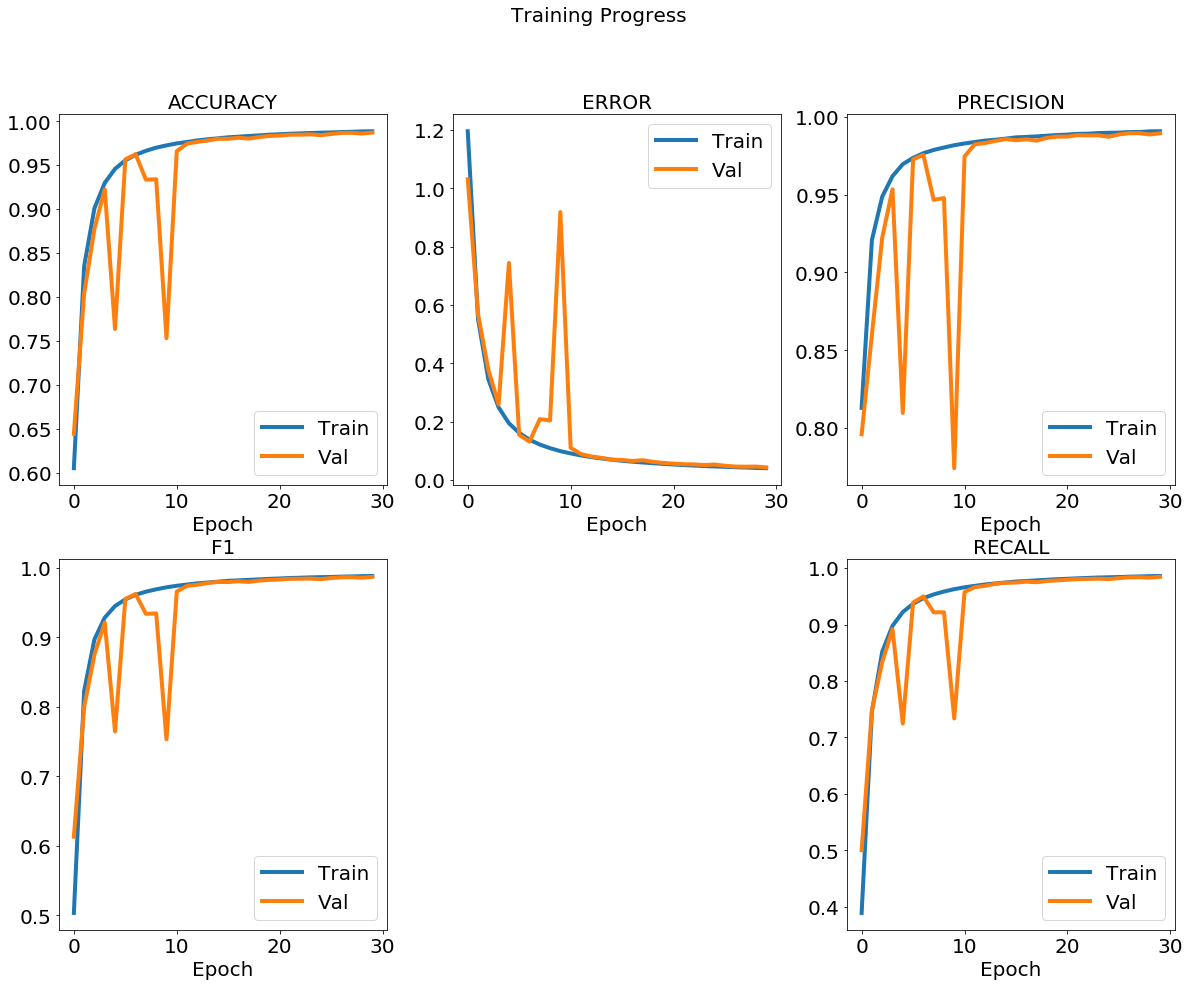

In [0]:
plot_training(history)
plt.show()

## Métricas para cada una de las categorías

In [0]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(np.asarray(y_test), axis=1)
y_pred = model.predict_classes(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       933
           1       0.98      0.96      0.97      1519
           2       0.99      0.99      0.99     14148
           3       0.99      0.99      0.99      1849
           4       0.99      0.99      0.99     13813
           5       0.99      0.99      0.99      9012
           6       0.98      0.98      0.98      2058
           7       0.98      0.96      0.97      2139
           8       0.98      0.98      0.98      5166
           9       0.99      0.99      0.99      4495
          10       0.99      0.99      0.99     12749
          11       0.98      0.97      0.98      2329
          12       0.97      0.96      0.97      2431

    accuracy                           0.99     72641
   macro avg       0.98      0.98      0.98     72641
weighted avg       0.99      0.99      0.99     72641

